In [2]:
import os
import math
import json
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow.keras as keras
import tensorflow as tf


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [4]:
def save_mfcc_to_json(dataset_path, 
                      json_path, 
                      track_duration=30, 
                      sr=22050, 
                      n_mfcc=13, 
                      n_fft=2048, 
                      hop_length=512, 
                      num_segments=10):
    # dictionary to store data
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": []
    }
    
    # mapping of labels to integers
    label_dict = {
        'jazz': 0,
        'reggae': 1,
        'rock': 2,
        'blues': 3,
        'hiphop': 4,
        'country': 5,
        'metal': 6,
        'classical': 7,
        'disco': 8,
        'pop': 9
    }
    
    samples_per_track = sr * track_duration
    num_samples_per_segment = int(samples_per_track / num_segments)
    expected_num_mfcc_per_segment = math.ceil(num_samples_per_segment / hop_length)
    
    # loop through files
    for file in os.scandir(dataset_path):
        
        # save semantic label
        data['mapping'].append(file.name.split('.')[0])
        
        # process files
        signal, sr = librosa.load(file, sr=sr)
        
        # process segments and extract mfccs
        for s in range(num_segments):
            start_sample = num_samples_per_segment * s
            finish_sample = start_sample + num_samples_per_segment
            
            #store mfcc for segment if has correct vector length
            mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample], 
                                        sr=sr,
                                        n_fft=n_fft,
                                        n_mfcc=n_mfcc, 
                                        hop_length=hop_length)
            
            mfcc = mfcc.T
            
            # make sure mfcc vectors are the same length (they could vary)
            if len(mfcc) == expected_num_mfcc_per_segment:
                data['mfcc'].append(mfcc.tolist())
                data["labels"].append(label_dict[data['mapping'][-1]])
            
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
        
    

In [5]:
save_mfcc_to_json('../../audio_files', '../data/data.json')

In [6]:
def load_data_from_json(dataset_path):
    with open(dataset_path, 'r') as fp:
        data = json.load(fp)
    
    inputs = np.array(data["mfcc"])
    targets = np.array(data['labels'])
    
    return inputs, targets

In [8]:
X, y = load_data_from_json('../data/data.json')
X.shape


(9996, 130, 13)

In [10]:
def prepare_datasets(data_path, test_size, validation_size):
    
    # load data
    X, y = load_data_from_json(data_path)
    
    # create train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    
    # create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, 
                                                                    y_train, 
                                                                    test_size=validation_size)
    
    
    X_train = X_train[..., np.newaxis] # 4d array -> (num_samples, 130, 13, 1)
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    return X_train, X_validation, X_test, y_train, y_validation, y_test
    

In [11]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets('../data/data.json', 0.25, 0.2)

In [251]:
def build_model(input_shape):
    # create model
    model = keras.Sequential()
    
    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))
    
    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # flatten the output and feed into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(32, activation='relu'))
    
    
    # output layer (softmax)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model
    
    

In [252]:
X_train.shape

(5997, 130, 13, 1)

In [253]:
# build CNN model
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = build_model(input_shape)

In [254]:
# compile model
optimizer = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [255]:
history = model.fit(X_train, 
          y_train, 
          validation_data=(X_validation, y_validation), 
          batch_size=32, 
          epochs=70)

Train on 5997 samples, validate on 1500 samples
Epoch 1/70
5997/5997 [==============================] - 1s 209us/sample - loss: 1.9972 - accuracy: 0.3063 - val_loss: 1.5500 - val_accuracy: 0.4433
Epoch 2/70
5997/5997 [==============================] - 1s 107us/sample - loss: 1.5468 - accuracy: 0.4442 - val_loss: 1.3402 - val_accuracy: 0.4873
Epoch 3/70
5997/5997 [==============================] - 1s 111us/sample - loss: 1.4002 - accuracy: 0.4952 - val_loss: 1.1488 - val_accuracy: 0.6027
Epoch 4/70
5997/5997 [==============================] - 1s 116us/sample - loss: 1.3041 - accuracy: 0.5276 - val_loss: 1.0973 - val_accuracy: 0.6007
Epoch 5/70
5997/5997 [==============================] - 1s 112us/sample - loss: 1.2322 - accuracy: 0.5644 - val_loss: 1.1835 - val_accuracy: 0.5520
Epoch 6/70
5997/5997 [==============================] - 1s 106us/sample - loss: 1.1783 - accuracy: 0.5768 - val_loss: 0.9750 - val_accuracy: 0.6467
Epoch 7/70
5997/5997 [==============================] - 1s 113us

Epoch 56/70
5997/5997 [==============================] - 1s 110us/sample - loss: 0.4805 - accuracy: 0.8316 - val_loss: 0.8094 - val_accuracy: 0.7547
Epoch 57/70
5997/5997 [==============================] - 1s 120us/sample - loss: 0.4880 - accuracy: 0.8321 - val_loss: 0.8526 - val_accuracy: 0.7380
Epoch 58/70
5997/5997 [==============================] - 1s 117us/sample - loss: 0.4704 - accuracy: 0.8359 - val_loss: 0.7845 - val_accuracy: 0.7633
Epoch 59/70
5997/5997 [==============================] - 1s 115us/sample - loss: 0.4604 - accuracy: 0.8381 - val_loss: 0.7232 - val_accuracy: 0.7833
Epoch 60/70
5997/5997 [==============================] - 1s 114us/sample - loss: 0.4744 - accuracy: 0.8336 - val_loss: 0.6605 - val_accuracy: 0.7947
Epoch 61/70
5997/5997 [==============================] - 1s 115us/sample - loss: 0.4889 - accuracy: 0.8289 - val_loss: 0.6695 - val_accuracy: 0.7913
Epoch 62/70
5997/5997 [==============================] - 1s 119us/sample - loss: 0.4761 - accuracy: 0.8307

In [246]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)


2499/2499 [==============================] - 0s 53us/sample - loss: 0.7540 - accuracy: 0.7367


In [177]:
X = X_test[300]
X.shape
#y = y_test[300]

(130, 13, 1)

In [178]:
def predict(model, X, y):
    
    # need to add the 4th dimension for the model
    X = X[np.newaxis, ...]
    
    # prediction is a 2d array
    predictions = model.predict(X)
    
    predicted_index = np.argmax(predictions, axis=1)
    
    return predicted_index, predictions
    
    

In [146]:
prediction, nList = predict(model, X, y)

In [148]:
prediction

array([9], dtype=int64)

In [149]:
nList

array([[0.00647148, 0.01127397, 0.14667226, 0.0015252 , 0.00349213,
        0.00495348, 0.00171214, 0.03255328, 0.0121196 , 0.7792264 ]],
      dtype=float32)

In [150]:
y

9

In [87]:
model.save('../models/cnn_model_80acc.h5')

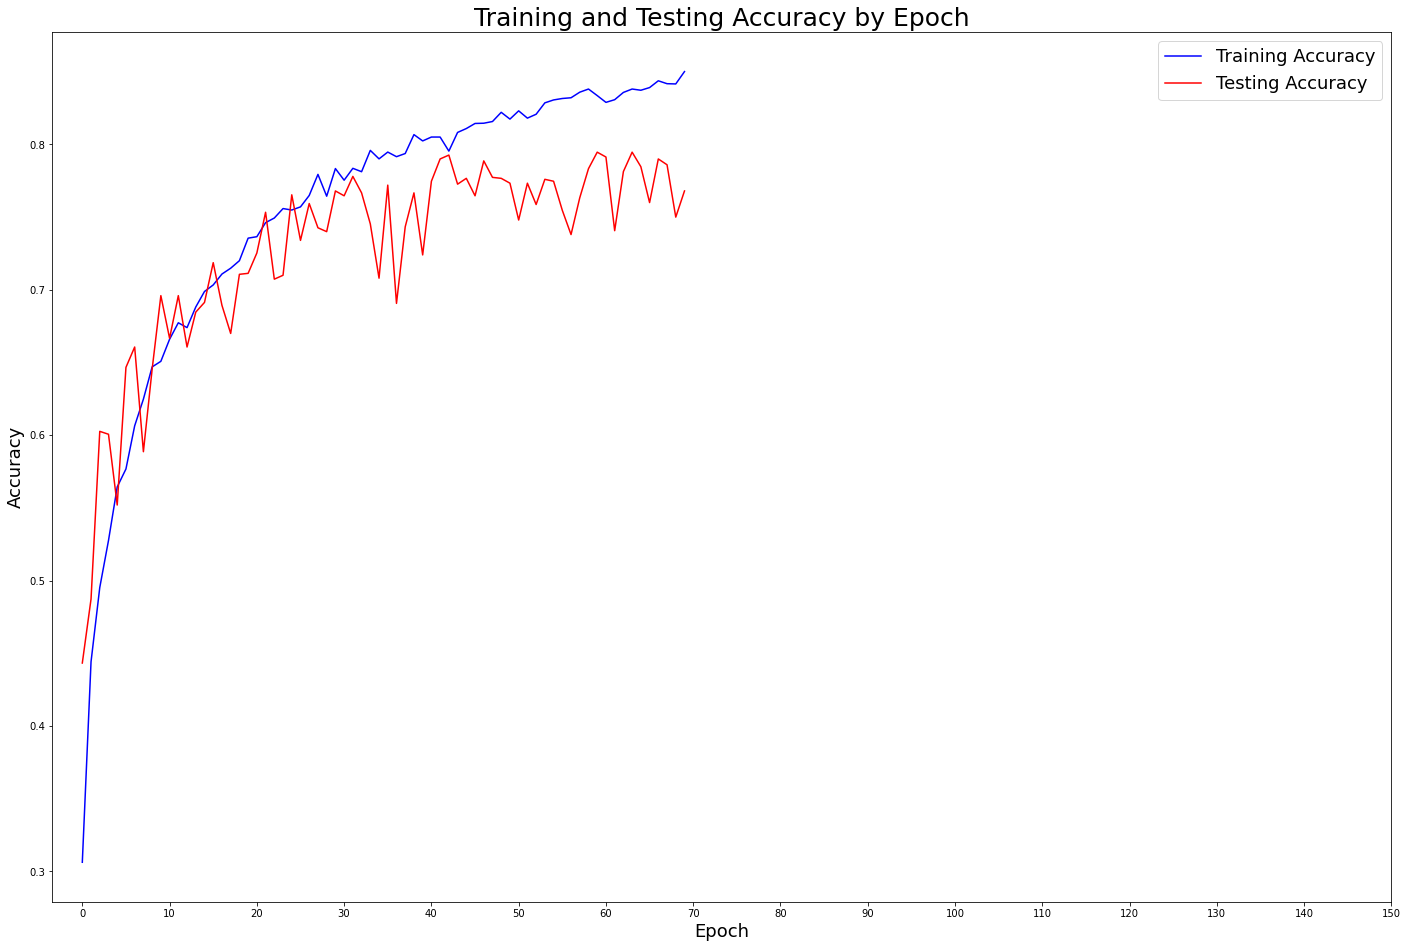

In [256]:
# Check out our train accuracy and test accuracy over epochs.
train_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(24, 16))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Accuracy', color='blue')
plt.plot(test_loss, label='Testing Accuracy', color='red')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks(range(0,160, 10), range(0,160, 10))

plt.legend(fontsize = 18);